## Recurrent Neural Network

Download any stock price data from https://www.nasdaq.com/market-activity/stocks/goog/historical
For this notebook, I have downloaed 1 year of google stock data


In [17]:
import pandas as pd
import numpy as np 

data = pd.read_csv('./data/HistoricalQuotes.csv')
data.columns = ['date', 'close', 'volume', 'open', 'high', 'low']
data.head()

,date,close,volume,open,high,low
0,03/09/2020,$1215.56,3365365,$1205.3,$1254.7599,$1200
1,03/06/2020,$1298.41,2660628,$1277.06,$1306.22,$1261.05
2,03/05/2020,$1319.04,2561288,$1350.2,$1358.91,$1305.1
3,03/04/2020,$1386.52,1913315,$1359.23,$1388.09,$1343.11
4,03/03/2020,$1341.39,2402326,$1399.42,$1410.15,$1332


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    252 non-null    object
 1   close   252 non-null    object
 2   volume  252 non-null    int64 
 3   open    252 non-null    object
 4   high    252 non-null    object
 5   low     252 non-null    object
dtypes: int64(1), object(5)
memory usage: 11.9+ KB


In [19]:
# Change date to datetime
data.date = pd.to_datetime(data.date)

# Handle the $ value in columns
currency_cols = ['close','high','open','low']
data[currency_cols] = data[currency_cols].apply(lambda x: x.str.replace('$','')).\
                apply(lambda x: x.str.replace(',','')).astype(np.float)

# volume column
data.volume = pd.to_numeric(data.volume)

data.head()

,date,close,volume,open,high,low
0,2020-03-09,1215.56,3365365,1205.30,1254.7599,1200.00
1,2020-03-06,1298.41,2660628,1277.06,1306.2200,1261.05
2,2020-03-05,1319.04,2561288,1350.20,1358.9100,1305.10
3,2020-03-04,1386.52,1913315,1359.23,1388.0900,1343.11
4,2020-03-03,1341.39,2402326,1399.42,1410.1500,1332.00


In [42]:
# Usefull columns
use_cols = ['close','volume','open','high','low']
use_data = data[use_cols]
use_data.describe()

,close,volume,open,high,low
count,252.000000,2.520000e+02,252.000000,252.000000,252.000000
mean,1249.327222,1.489360e+06,1247.954385,1258.647470,1238.697376
std,114.765573,6.897266e+05,114.297763,115.373106,113.631584
min,1036.230000,3.475180e+05,1042.900000,1047.490000,1025.000000
25%,1168.790000,1.088108e+06,1171.105000,1180.355725,1160.407500
50%,1219.585000,1.324190e+06,1219.700000,1231.510000,1210.385000
75%,1319.415000,1.654379e+06,1321.130000,1330.738425,1310.422500
max,1526.690000,6.194691e+06,1525.070000,1532.106300,1521.400000


In [43]:
# Normalize the data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

columnTransformer = ColumnTransformer([
                                       ('close_scaled', RobustScaler(), ['close']),
                                        ('volume_scaled', RobustScaler(),['volume']),
                                       ('open_scaled', RobustScaler(), ['open']),
                                       ('high_scaled', RobustScaler(), ['high']),
                                       ('low_scaled', RobustScaler(), ['low']),
                                      ], remainder='drop')

use_data = pd.DataFrame(columnTransformer.fit_transform(use_data))
use_data.columns = ['close','volume','open','high','low']

In [44]:
use_data.head()

,close,volume,open,high,low
0,-0.026722,3.604594,-0.095984,0.154605,-0.069226
1,0.523320,2.360071,0.382336,0.496799,0.337733
2,0.660282,2.184642,0.869855,0.847172,0.631370
3,1.108282,1.040361,0.930045,1.041210,0.884745
4,0.808664,1.903925,1.197934,1.187903,0.810686


In [77]:
# Feature columns
feature_cols = ['close','volume','open','high','low']
# 
label_col = ['close']



In [78]:
use_data.loc[range(0,2),feature_cols].values.tolist()

[[-0.026721991701245416,
  3.6045944473533407,
  -0.09598400266622284,
  0.1546048847374067,
  -0.069226410692264],
 [0.5233195020746891,
  2.3600708495321583,
  0.3823362772871179,
  0.49679916639347466,
  0.3377328933773285]]

## Prediction Problem

Using the last 30 days including the current date, we want to predict the closing stock price for the next 7 days

In [79]:
history_size = 25
target_size = 7

start_index = history_size
end_index = len(use_data) - target_size

data = []
labels = []

for i in range(start_index, end_index):
    data_indices = range(i - history_size, i, 1)
    data.append(use_data.loc[data_indices, feature_cols].values.tolist())
    label_indices = range(i, i + target_size)
    labels.append(use_data.loc[label_indices, label_col].values.tolist())



data = np.array(data)
labels = np.array(labels)

print("Data shape {}".format(data.shape))
print("Label Shape {}".format(labels.shape))


Data shape (220, 25, 5)
Label Shape (220, 7, 1)


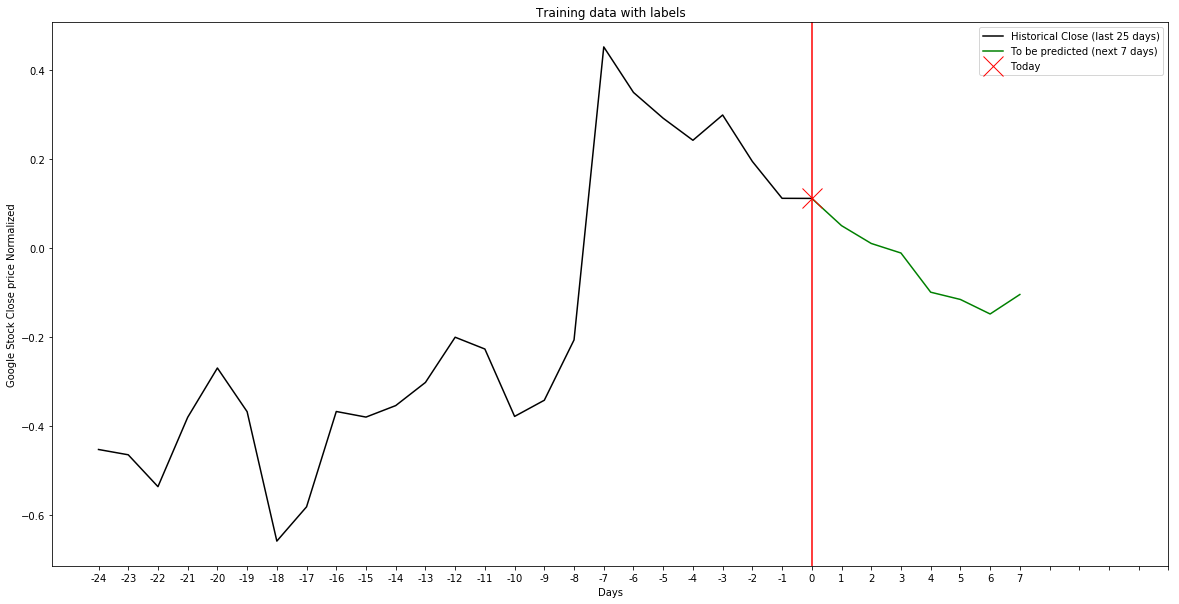

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

day = 200
plt.plot(range(0, 25), data[day][:,0], 'k-', label = 'Historical Close (last 25 days)')
plt.plot(range(24, 32), np.concatenate([ [data[day][24,0]], np.squeeze(labels[day])]), 'g-', label = 'To be predicted (next 7 days)')
plt.axvline(x=24, c = 'r')
plt.plot(24, data[day][24,0], 'rx', markersize = 20, label = "Today")
plt.xticks(range(0, 37), range(-24, 8))
plt.title('Training data with labels')
plt.xlabel('Days')
plt.ylabel('Google Stock Close price Normalized')
plt.legend()
plt.show()

In [155]:
# Train test split
X_train = data[0:200]
X_valid = data[200:210]
X_test = data[210:]

print("X shape {}".format(X_train.shape))

y_train = labels[0:200]
y_valid = labels[200:210]
y_test = labels[210:]

print("y shape {}".format(y_train.shape))



X shape (200, 25, 5)
y shape (200, 7, 1)


In [140]:
## Model Building Function

import tensorflow as tf
from tensorflow import keras

def make_model(learning_rate):
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(24, input_shape = (25,5), return_sequences = True ),
        keras.layers.SimpleRNN(12),


        keras.layers.Dense(7, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                 loss=keras.losses.MeanSquaredError(),
                 metrics=[keras.metrics.MeanAbsoluteError(name='mae')])
    return model


base_model = make_model(3e-4)
base_model.summary()
    
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 25, 24)            720       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 12)                444       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 91        
Total params: 1,255
Trainable params: 1,255
Non-trainable params: 0
_________________________________________________________________


In [141]:
# Single Forward Probagation

base_predictions = base_model.predict(X_train[0:5])
print("Predictions output shape {}".format(base_predictions.shape))
base_predictions

Predictions output shape (5, 7)


array([[-3.15186262e-01, -1.47983050e+00, -1.12257218e+00,
        -1.97999075e-01,  1.97958946e-03, -1.16632915e+00,
         2.03163576e+00],
       [-2.47014165e-01, -1.48327780e+00, -7.27626026e-01,
        -2.40097612e-01, -1.33600235e-02, -1.12127924e+00,
         1.90332353e+00],
       [-3.31801057e-01, -1.22570181e+00, -1.88412026e-01,
        -8.22094798e-01, -4.21522349e-01, -9.23003674e-01,
         1.33115613e+00],
       [-2.43491024e-01, -8.54668677e-01,  2.58712828e-01,
        -1.06844354e+00, -2.98608631e-01, -6.57446235e-02,
         5.86021900e-01],
       [ 1.01859570e-02, -5.36465168e-01, -2.26117581e-01,
        -9.88587379e-01, -3.00856978e-01,  2.76331663e-01,
         5.25594831e-01]], dtype=float32)

In [142]:
results = base_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Training Loss: {:0.4f}".format(results[0]))



Training Loss: 1.2539


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
base_model.save_weights(initial_weights)

In [186]:
import os
import tempfile

BATCH_SIZE = 4
EPOCHS = 150
LEARNING_RATE =1e-7

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', 
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True)


# This function keeps the learning rate at LEARNING_RATE for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch):
  if epoch < 2:
    return LEARNING_RATE
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [187]:
model = make_model(LEARNING_RATE)
model.load_weights(run_weights)
first_run_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid), 
    callbacks =[early_stopping, lrscheduler],
    verbose=1)


Train on 200 samples, validate on 10 samples
Epoch 1/150
200/200 [==============================] - 1s 6ms/sample - loss: 0.0582 - mae: 0.1779 - val_loss: 0.0077 - val_mae: 0.0669
Epoch 2/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0582 - mae: 0.1778 - val_loss: 0.0077 - val_mae: 0.0669
Epoch 3/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0481 - mae: 0.1664 - val_loss: 0.0253 - val_mae: 0.1250
Epoch 4/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0440 - mae: 0.1592 - val_loss: 0.0186 - val_mae: 0.1038
Epoch 5/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0383 - mae: 0.1490 - val_loss: 0.0216 - val_mae: 0.1206
Epoch 6/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0415 - mae: 0.1521 - val_loss: 0.0104 - val_mae: 0.0797
Epoch 7/150
200/200 [==============================] - 0s 2ms/sample - loss: 0.0363 - mae: 0.1409 - val_loss: 0.0096 - val_mae: 0.0807
Epoch 8/15

In [188]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Training Loss: {:0.4f}".format(results[0]))

results = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE, verbose=0)
print("Validation Loss: {:0.4f}".format(results[0]))



results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print("Test Loss: {:0.4f}".format(results[0]))




Training Loss: 0.0582
Validation Loss: 0.0077
Test Loss: 0.0239


In [189]:
import uuid 
run_id = uuid.uuid1()
run_weights = os.path.join(tempfile.mkdtemp(),str(run_id))
model.save_weights(run_weights)

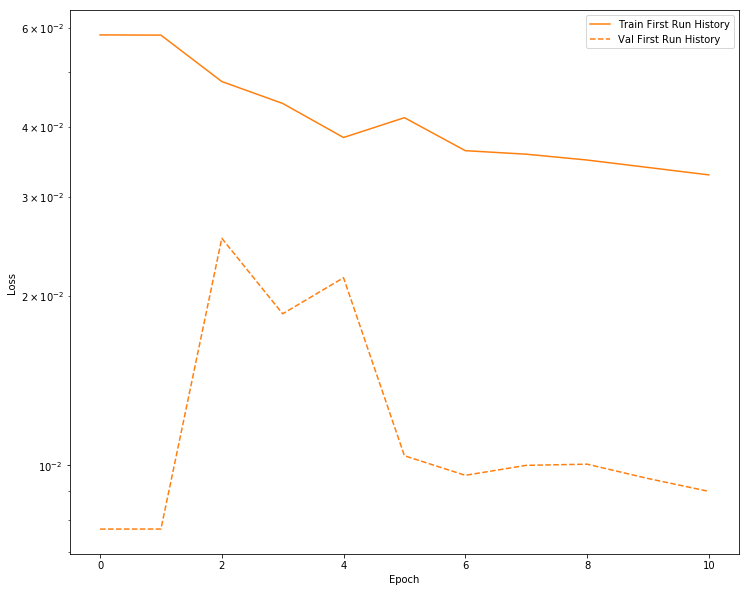

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

plot_loss(first_run_history, 'First Run History',1)

In [201]:
## prediction vs actual

predictions = model.predict(X_test)
predictions.shape


(10, 7)

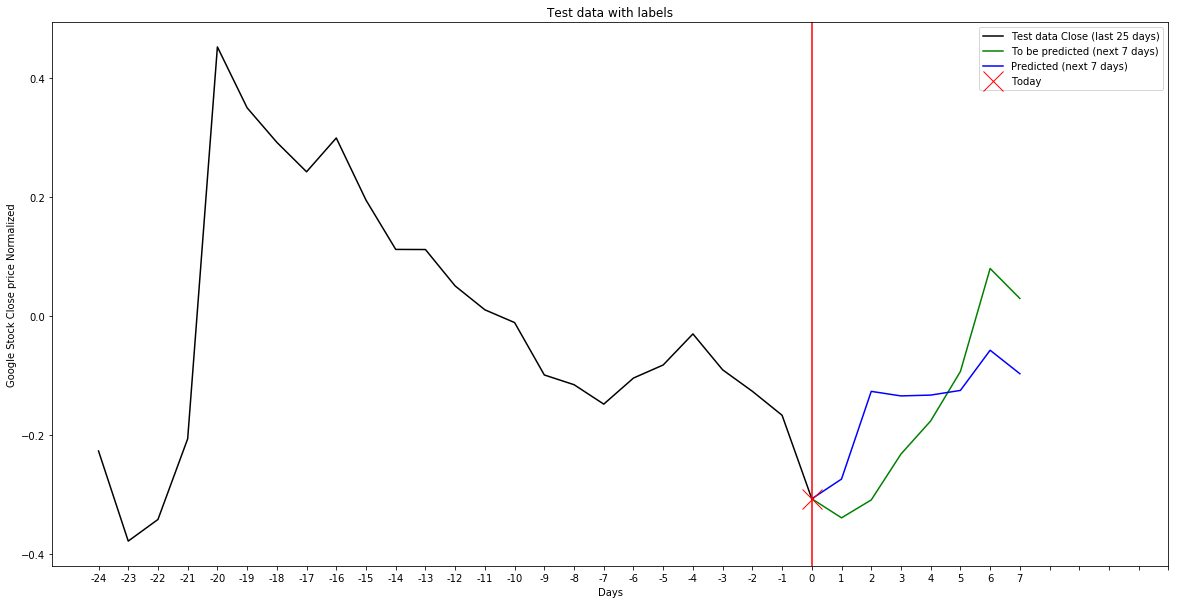

In [202]:
plt.rcParams["figure.figsize"] = (20,10)

day = 3
plt.plot(range(0, 25), X_test[day][:,0], 'k-', label = 'Test data Close (last 25 days)')
plt.plot(range(24, 32), np.concatenate([ [X_test[day][24,0]], np.squeeze(y_test[day])]), 'g-', label = 'To be predicted (next 7 days)')
plt.plot(range(24, 32), np.concatenate([ [X_test[day][24,0]], np.squeeze(predictions[day])]), 'b-', label = 'Predicted (next 7 days)')


plt.axvline(x=24, c = 'r')
plt.plot(24, X_test[day][24,0], 'rx', markersize = 20, label = "Today")
plt.xticks(range(0, 37), range(-24, 8))
plt.title('Test data with labels')
plt.xlabel('Days')
plt.ylabel('Google Stock Close price Normalized')
plt.legend()
plt.show()